In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')

# 3D deltas


## Available Data

### Scenarios

The following high resolution (R2B9) Monsoon 2.0 (M2; see [repository](https://gitlab.dkrz.de/monsoon2/rundir)) experimens with a default microphysics setup are available:

* `l100X` : piControl
* `l101X` : ssp245
* `l102X` : ssp585
* `l103X` : piControl-p1K

In our previous notbook we looked at the SSP245 (=RCP4.5) versus piControl scenarios. Although SSP245 and SSP585 are different emission scenarios (representing 4.5 and 8.5 W/ms2 additional radiative forcing respectively; e.g. [O’Neill et al, 2016](https://doi.org/10.5194/gmd-9-3461-2016)), they did not differ too much on a first glance. This might be because in M2 they both are still in a transient state (year 2070) and have not developed their full warming potential. In the SSP245 mini ensemble there is only one experiment with 3D output available. I will thus look at the SSP585 experiments, to allow averaging over multiple runs.

In [2]:
import prelim

mcat = prelim.monsooon_catalog()

for prefix in ['luk100', 'luk101', 'luk102']:
    print(prefix+'X:')
    for experiment in [item for item in list(mcat) if prefix in item]: 
        print(f"  {experiment} has 3D data: {'atm3d' in list(mcat[experiment])}")
    print()

luk100X:
  luk1000 has 3D data: False
  luk1001 has 3D data: True
  luk1002 has 3D data: True
  luk1003 has 3D data: True

luk101X:
  luk1010 has 3D data: False
  luk1011 has 3D data: True

luk102X:
  luk1020 has 3D data: False
  luk1021 has 3D data: True
  luk1022 has 3D data: True
  luk1023 has 3D data: True



### Variables

In [3]:
import numpy as np
import plot_utils as pu
    
def get_time_offset(a,b):
    if a.time.values[0] > b.time.values[0]:
        print('swapping')
        swap = a
        a = b
        b = swap
    return b.time.values[0] - a.time.values[0]

def drop_extra_timesteps(a,b):
    if   len(a.time.values) > len(b.time.values):
        long = a; short = b; order='ab'
    elif len(a.time.values) < len(b.time.values):
        long = b; short = a; order='ba'
    else: # equal length
        return a,b
    
    extras = long.time.values[np.isin(long.time, short.time, invert=True)]
    for extra in extras:
        long = long.where(long.time != extra, drop=True)
    if order == 'ab':
        return long, short
    else:
        return short, long

def extract_month(data, month):
    if type(month) == type('string'):
        month = pu.month2int(month)
    # https://stackoverflow.com/a/60793478
    month_idxs=data.groupby('time.month').groups[month]
    return data.isel(time=month_idxs)

def discard_first_time_step(data):
    return data.isel(time=[i + 1 for i in range(int(np.ravel(data.time.shape))-1)])

In [4]:
domain_limits = prelim.latlon_limits(prelim.eureca_grid())
month = 'April'
data = prelim.cut_latlon_box(prelim.monsoon_dataset('luk1011', grid=True, type='atm3d'), domain_limits)
data = extract_month(data, month) 
data = discard_first_time_step(data).mean(dim='time')

print('Available 3D variables:')
for var in list(data):
    try: print(f"  {var.ljust(8)} : {data[var].attrs['name']}")
    except: pass

Available 3D variables:
  cli      : specific cloud ice content
  clw      : specific cloud water content
  hus      : specific humidity
  pfull    : air pressure
  qg       : specific graupel content
  qr       : specific rain content
  qs       : specific snow content
  rho      : air density
  ta       : air temperature
  ua       : eastward wind
  va       : northward wind
  wa       : upward air velocity
  zg       : full level geopot. height
  zghalf   : full level geopot. height


## Domain means

We have looked at the 2D data before. But not at an ensemble, so lets have a brief look at domain sea surface temperature domain means.

In [5]:
varname='ts'
ctrl = prelim.cut_latlon_box(prelim.monsoon_dataset('luk1000', grid=True), domain_limits)[varname]

print(f"{ctrl.attrs['name']} averaged over eureca region for month {month}")
print('  ctrl:  ', extract_month(ctrl, month).mean(dim='time').mean(dim='cell').values)
print('  ssp245:', extract_month(prelim.cut_latlon_box(prelim.monsoon_dataset('luk1011', grid=True), domain_limits)[varname], month).mean(dim='time').mean(dim='cell').values)
print('  ssp585:', extract_month(prelim.cut_latlon_box(prelim.monsoon_dataset('luk1021', grid=True), domain_limits)[varname], month).mean(dim='time').mean(dim='cell').values)
print('  ssp585:', extract_month(prelim.cut_latlon_box(prelim.monsoon_dataset('luk1022', grid=True), domain_limits)[varname], month).mean(dim='time').mean(dim='cell').values)
print('  ssp585:', extract_month(prelim.cut_latlon_box(prelim.monsoon_dataset('luk1023', grid=True), domain_limits)[varname], month).mean(dim='time').mean(dim='cell').values)

surface temperature averaged over eureca region for month April
  ctrl:   300.10297
  ssp245: 301.10077
  ssp585: 301.52014
  ssp585: 300.64636
  ssp585: 300.94138


In [6]:
ctrl   = np.asarray([300.1078])
ssp585 = np.asarray([301.5224, 300.6452, 300.9416])
print(f"mean delta T : {np.mean(ssp585) - np.mean(ctrl)}")

mean delta T : 0.9286000000000172


Our aim was to look at vertical profiles. We will get ensemble means for the control and for the SSP585 scenarios.

In [7]:
import prelim
import xarray as xr

def monsoon_3d_data_available(experiment):
    mcat = prelim.monsooon_catalog()
    return 'atm3d' in list(mcat[experiment])

def get_3d_ensemble(experiment_names): 
    for experiment in experiment_names:
        if not monsoon_3d_data_available(experiment): raise ValueError(f"no 3D data available for {experiment}") 
    ensemble = list()
    for experiment in experiment_names:
        data = prelim.monsoon_dataset(experiment, grid=True, type='atm3d')
        ensemble.append(data.expand_dims(dim='member'))
    return xr.concat(ensemble, dim='member')

def cut_out_eureca_domain(dataset):
    domain_limits = prelim.latlon_limits(prelim.eureca_grid())    
    return prelim.cut_latlon_box(dataset, domain_limits)

def drop_all_except(dataset, conserved_variables):
    drops = [e for e in list(dataset) if not e in conserved_variables]
    return dataset.drop_vars(drops)

def get_3d_eureca_april_ensemble(exp_list, discard_spinup=True):
    data = get_3d_ensemble(exp_list)
    data = cut_out_eureca_domain(data)
    data = extract_month(data, 'april')
    if discard_spinup:
        data = discard_first_time_step(data)
    # data = data.dropna(dim='fulllevel')
    return data

def get_3d_eureca_april_ensemble_mean(exp_list, dimensions=['time','member','cell']):
    return get_3d_eureca_april_ensemble(exp_list).mean(dim=dimensions)

def ensemble_quantile(data, quantile, dimensions=['time','member','cell']):
    data = data.stack(profile=dimensions)
# i meant to use xarray, but it doesnt behave.
    # data = data.quantile(quantile, 'profile')
    return np.quantile(data.values, quantile, axis=1)

def get_3d_eureca_april_ensemble_quantile(exp_list, variable, quantile, dimensions=['time','member','cell']):
    data = get_3d_eureca_april_ensemble(exp_list)
    data = ensemble_quantile(data[variable], quantile, dimensions)
    return data

def drop_nan(x):
    # https://stackoverflow.com/a/47486199
    return x[~np.isnan(x)]

In [8]:
import matplotlib.pyplot as plt

def variable_comparison_plot(variable, warming_ensemble, control_ensemble, title, 
                             quartiles = (0.25, 0.75), reduced_dimensions = ['time','member','cell']):
    (q1, q2) = quartiles
    p = warming_ensemble[variable]
    pm = p.mean(dim=reduced_dimensions).values
    pq = ( ensemble_quantile(p, q1, reduced_dimensions), 
           ensemble_quantile(p, q2, reduced_dimensions))
    c = control_ensemble[variable]
    cm = c.mean(dim=reduced_dimensions).values
    cq = ( ensemble_quantile(c, q1, reduced_dimensions), 
           ensemble_quantile(c, q2, reduced_dimensions))

    pm = drop_nan(pm)
    pq = ( drop_nan(pq[0]), 
           drop_nan(pq[1]))
    cm = drop_nan(cm)
    cq = ( drop_nan(cq[0]), 
           drop_nan(cq[1]))
    
    x = np.asarray(range(len(pm)))
    attrs = warming_ensemble[variable].attrs

    # gridspec: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(1, 2,  width_ratios=(5, 3),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    axs = [fig.add_subplot(gs[0, 0])]
    axs.append(fig.add_subplot(gs[0, 1], sharey=axs[0]))

    ax = axs[0]
    ax.fill_betweenx(x,*cq, color='tab:blue',  alpha=0.4, label='interquartile range')
    ax.plot(cm, x, color='tab:blue', label='ctrl')
    ax.fill_betweenx(x,*pq, color='tab:orange',  alpha=0.4)#, label='interquartile range')
    ax.plot(pm, x, color='tab:orange', label='plus')
    subplottitle = f"{attrs['name']}"
    try: 
        subplottitle += f"/ {attrs['units']}"
    except: pass
    ax.set_xlabel(subplottitle)
    ax.set_ylabel('Model height level')
    ax.legend(borderaxespad=2)
    pu.remove_spines(ax)
    ax.invert_yaxis()

    ax = axs[1]
    ax.fill_betweenx(x, (pm-cm), np.zeros(len(x)), (pm-cm)>np.zeros(len(x)), label='diff', color='red',  alpha=0.4)
    ax.fill_betweenx(x, (pm-cm), np.zeros(len(x)), (pm-cm)<np.zeros(len(x)), label='diff', color='blue', alpha=0.4)
    ax.fill_betweenx(x, (pq[0]-cq[0]), (pq[1]-cq[1]), color='grey',  alpha=0.4, label='interquartile range')
    ax.plot((pm-cm),x, color='grey')
    subplottitle = f"$\Delta$ {attrs['name']}"
    try: 
        subplottitle += f"/ {attrs['units']}"
    except: pass
    ax.set_xlabel(subplottitle)
    pu.remove_spines(ax)

    fig.suptitle(title)
    return fig, axs


In [9]:
import matplotlib.pyplot as plt

def variable_comparison_plot(variable, warming_ensemble, control_ensemble, title, 
                             quartiles = (0.25, 0.75), reduced_dimensions = ['time','member','cell']):
    (q1, q2) = quartiles
    p = warming_ensemble[variable]
    pm = p.mean(dim=reduced_dimensions).values
    pq = ( ensemble_quantile(p, q1, reduced_dimensions), 
           ensemble_quantile(p, q2, reduced_dimensions))
    c = control_ensemble[variable]
    cm = c.mean(dim=reduced_dimensions).values
    cq = ( ensemble_quantile(c, q1, reduced_dimensions), 
           ensemble_quantile(c, q2, reduced_dimensions))

    timeandspace=[dim for dim in reduced_dimensions if dim != 'member']
    p_member = []
    for member in p.mean(dim=timeandspace).values:
        p_member.append(drop_nan(member))
    c_member = []
    for member in c.mean(dim=timeandspace).values:
        c_member.append(drop_nan(member))
        
    pm = drop_nan(pm)
    pq = ( drop_nan(pq[0]), 
           drop_nan(pq[1]))
    cm = drop_nan(cm)
    cq = ( drop_nan(cq[0]), 
           drop_nan(cq[1]))
    
    x = np.asarray(range(len(pm)))
    attrs = warming_ensemble[variable].attrs

    # gridspec: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(1, 2,  width_ratios=(5, 3),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    axs = [fig.add_subplot(gs[0, 0])]
    axs.append(fig.add_subplot(gs[0, 1], sharey=axs[0]))

    ax = axs[0]
    ax.fill_betweenx(x,*cq, color='tab:blue',  alpha=0.4, label='interquartile range')
    ax.fill_betweenx(x,*pq, color='tab:orange',  alpha=0.4)#, label='interquartile range')
    
    for i,m in enumerate(c_member):
        if i == 0:
            ax.plot(m, x, color='tab:blue', ls=':', label='ensemble member')
        else:
            ax.plot(m, x, color='tab:blue', ls=':')
    for m in p_member:
        ax.plot(m, x, color='tab:orange', ls=':')
        
    ax.plot(cm, x, color='tab:blue', label='ctrl')    
    ax.plot(pm, x, color='tab:orange', label='plus')
    
    subplottitle = f"{attrs['name']}"
    try: 
        subplottitle += f"/ {attrs['units']}"
    except: pass
    ax.set_xlabel(subplottitle)
    ax.set_ylabel('Model height level')
    ax.legend(borderaxespad=2)
    pu.remove_spines(ax)
    ax.invert_yaxis()

    ax = axs[1]
    ax.fill_betweenx(x, (pm-cm), np.zeros(len(x)), (pm-cm)>np.zeros(len(x)), label='diff', color='red',  alpha=0.4)
    ax.fill_betweenx(x, (pm-cm), np.zeros(len(x)), (pm-cm)<np.zeros(len(x)), label='diff', color='blue', alpha=0.4)
    ax.fill_betweenx(x, (pq[0]-cq[0]), (pq[1]-cq[1]), color='grey',  alpha=0.4, label='interquartile range')
    ax.plot((pm-cm),x, color='grey')
    subplottitle = f"$\Delta$ {attrs['name']}"
    try: 
        subplottitle += f"/ {attrs['units']}"
    except: pass
    ax.set_xlabel(subplottitle)
    pu.remove_spines(ax)

    fig.suptitle(title)
    return fig, axs


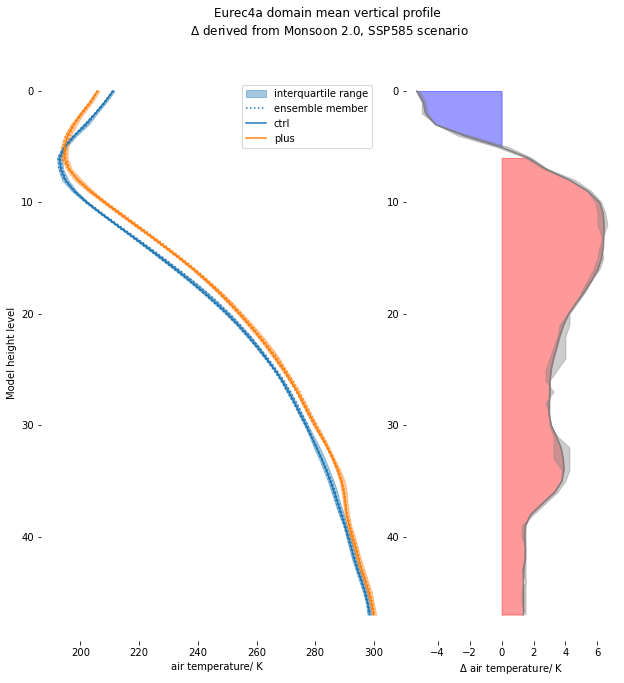

In [10]:
variable = 'ta'
warming_ensemble = get_3d_eureca_april_ensemble(['luk1021', 'luk1022', 'luk1023'])
control_ensemble = get_3d_eureca_april_ensemble(['luk1001', 'luk1002', 'luk1003'])
title = "Eurec4a domain mean vertical profile \n$\Delta$ derived from Monsoon 2.0, SSP585 scenario"    

variable_comparison_plot(variable, warming_ensemble, control_ensemble, title)
plt.show()

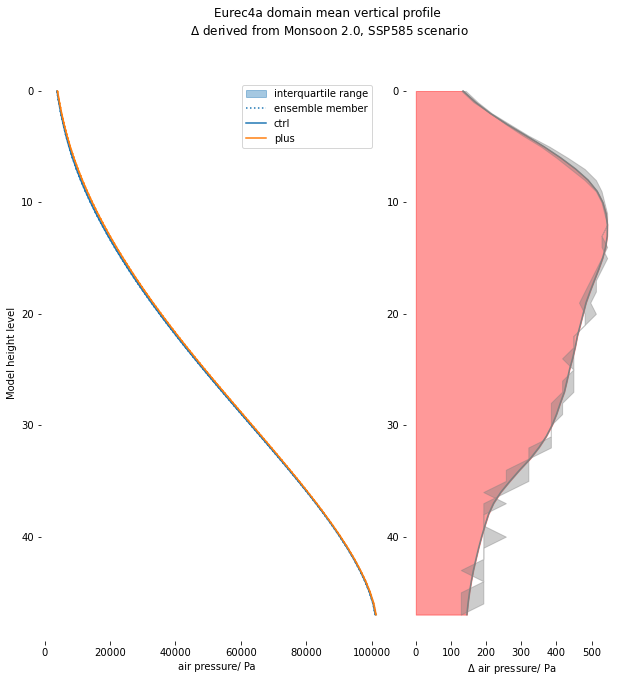

In [11]:
variable = 'pfull'
variable_comparison_plot(variable, warming_ensemble, control_ensemble, title)
plt.show()

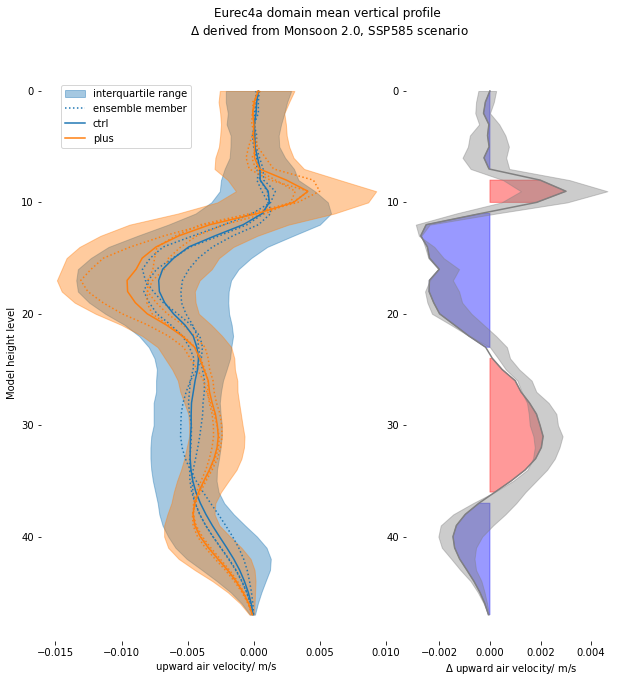

In [12]:
variable = 'wa'
variable_comparison_plot(variable, warming_ensemble, control_ensemble, title)
plt.show()

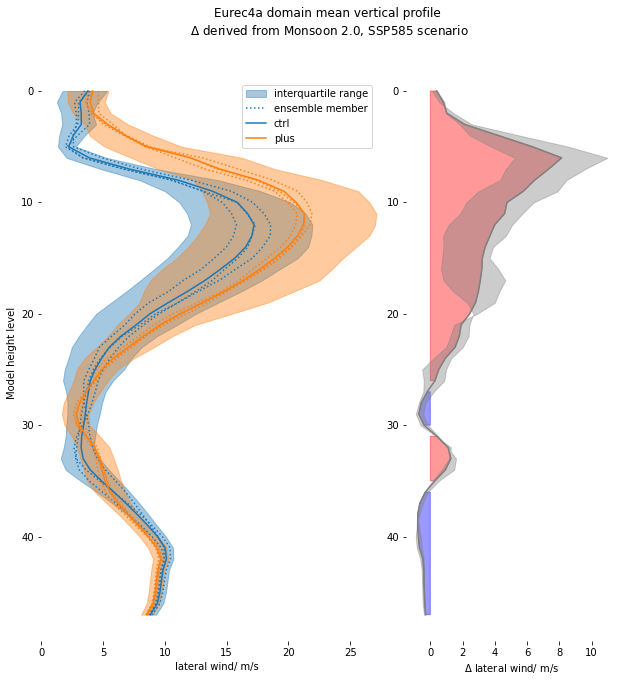

In [13]:
def add_total_wind(dataset, new_name='total_wind', drop=False):
    variables = list(dataset)
    dataset[new_name] = np.sqrt(dataset['ua'] **2 + dataset['va'] **2)
    dataset[new_name].attrs['name'] = 'lateral wind'
    if drop: dataset = dataset.drop_vars(variables)
    return dataset

warm = add_total_wind(warming_ensemble) 
cold = add_total_wind(control_ensemble) 

variable = 'total_wind'

variable_comparison_plot(variable, warm, cold, title)
plt.show()

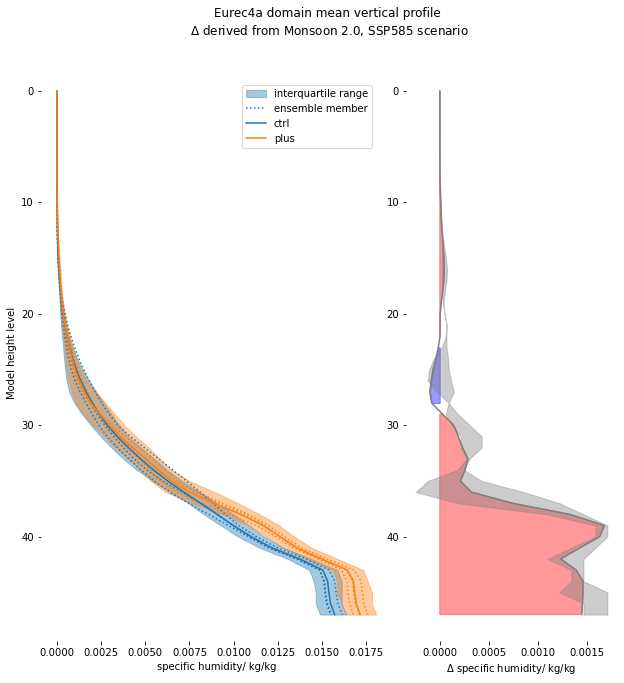

In [14]:
variable = 'hus'
variable_comparison_plot(variable, warm, cold, title)
plt.show()

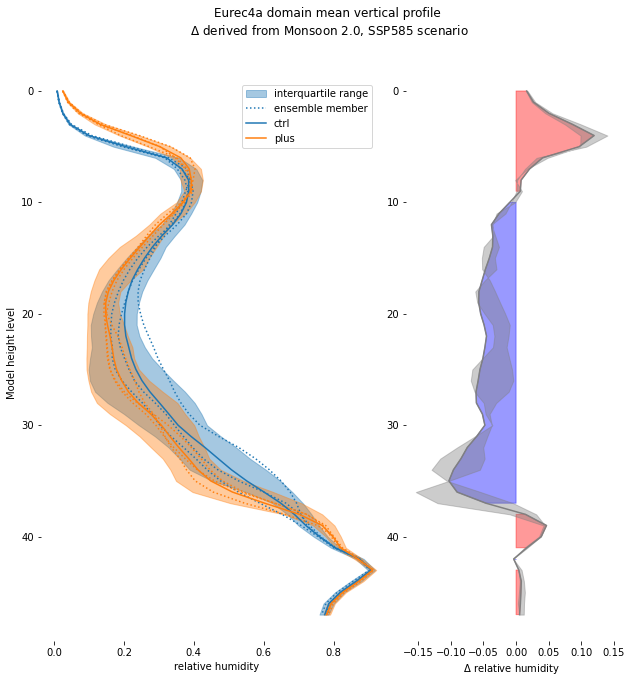

In [15]:
import metpy.calc as mpcalc
from metpy.units import units

def add_relative_humidity(dataset, new_name='rh', drop=False):
    variables = list(dataset)
    p  = dataset['pfull'] * units('pascal')
    t  = dataset['ta'] * units('kelvin')
    qv = dataset['hus']   # ratio of water vapor mass to total moist air parcel mass
    dataset[new_name] = mpcalc.relative_humidity_from_specific_humidity(p, t, qv)
    dataset[new_name].attrs['name'] = 'relative humidity'
    if drop: dataset = dataset.drop_vars(variables)
    return dataset

warm = add_relative_humidity(warming_ensemble) 
cold = add_relative_humidity(control_ensemble) 
variable = 'rh'

variable_comparison_plot(variable, warm, cold, title)
plt.show()

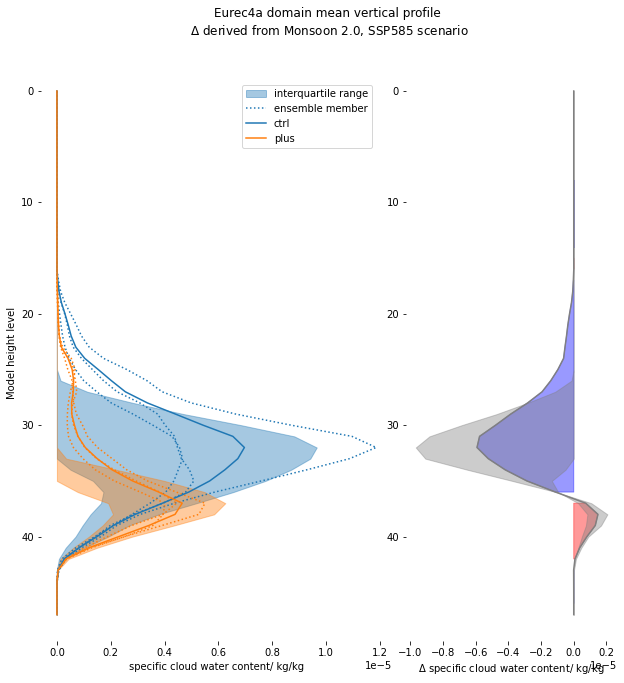

In [16]:
variable = 'clw'
variable_comparison_plot(variable, warm, cold, title)
plt.show()

## Save a reduced dataset to work on the adiabat construction

In [17]:
warming_ensemble = get_3d_eureca_april_ensemble(['luk1021', 'luk1022', 'luk1023'])
control_ensemble = get_3d_eureca_april_ensemble(['luk1001', 'luk1002', 'luk1003'])
warm = warming_ensemble.copy().mean(dim=['time','member','cell'])
cold = control_ensemble.copy().mean(dim=['time','member','cell'])
cold.to_netcdf('luk100X_control.nc')
warm.to_netcdf('luk102X_ssp585.nc')